In [1]:
import pandas as pd

# Chargement du jeu de données
data = pd.read_csv("../data/BenignAndMaliciousDataset.csv")

In [2]:
print(data.columns)


Index(['Domain', 'DNSRecordType', 'MXDnsResponse', 'TXTDnsResponse',
       'HasSPFInfo', 'HasDkimInfo', 'HasDmarcInfo', 'Ip', 'DomainInAlexaDB',
       'CommonPorts', 'CountryCode', 'RegisteredCountry', 'CreationDate',
       'LastUpdateDate', 'ASN', 'HttpResponseCode', 'RegisteredOrg',
       'SubdomainNumber', 'Entropy', 'EntropyOfSubDomains',
       'StrangeCharacters', 'TLD', 'IpReputation', 'DomainReputation',
       'ConsoantRatio', 'NumericRatio', 'SpecialCharRatio', 'VowelRatio',
       'ConsoantSequence', 'VowelSequence', 'NumericSequence',
       'SpecialCharSequence', 'DomainLength', 'Class'],
      dtype='object')


In [3]:
# Séparation des fonctionnalités et de la cible
X = data[['DNSRecordType', 'NumericSequence', 'NumericRatio', 'StrangeCharacters', 'ConsoantRatio', 'VowelRatio']]
y = data['Class']


In [4]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
import numpy as np

from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [5]:
#Avant l'encodage de l'attribut categroriciel

categorical_feature = X['DNSRecordType']

print(categorical_feature)


0        A
1        A
2        A
3        A
4        A
        ..
89995    A
89996    A
89997    A
89998    A
89999    A
Name: DNSRecordType, Length: 90000, dtype: object


In [6]:

# Définition de la taille du vocabulaire
vocab_size = 10000

# Création de la couche TextVectorization pour l'encodage des fonctionnalités textuelles
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int', 
    output_sequence_length=100)  # Taille fixe pour chaque séquence de fonctionnalités textuelles

# Adaptation de la couche TextVectorization aux données textuelles 
dns_data = X['DNSRecordType'].astype(str)


vectorize_layer.adapt(dns_data)


In [7]:
# Données encodées et prétraitées
encoded_dns_data = np.array(vectorize_layer(dns_data))


In [8]:
#affichage de l'attribut apres vectorisation

print (encoded_dns_data)

[[2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


In [9]:
#avant l'encodage

numeric_features = ['NumericSequence', 'NumericRatio', 'StrangeCharacters', 'ConsoantRatio','VowelRatio']
print (data[numeric_features])

       NumericSequence  NumericRatio  StrangeCharacters  ConsoantRatio   
0                    1           0.1                 11            0.6  \
1                    2           0.1                 11            0.7   
2                    3           0.2                 24            0.6   
3                    2           0.1                 15            0.6   
4                    2           0.2                 23            0.6   
...                ...           ...                ...            ...   
89995                2           0.2                  3            0.5   
89996                0           0.0                  0            0.6   
89997                2           0.1                  1            0.5   
89998                0           0.0                  0            0.5   
89999                0           0.0                  1            0.6   

       VowelRatio  
0             0.2  
1             0.2  
2             0.2  
3             0.1  
4          

In [10]:
# Sélection des fonctionnalités numériques
numeric_features = X[['NumericSequence', 'NumericRatio', 'StrangeCharacters', 'ConsoantRatio','VowelRatio']]

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(numeric_features)

# Transformation des fonctionnalités numériques
scaled_numeric_features = scaler.transform(numeric_features)

In [11]:
# Apres transformation

# Création d' un DataFrame à partir des valeurs transformées
scaled_df = pd.DataFrame(scaled_numeric_features, columns=numeric_features.columns)

# Afficher le DataFrame avec les valeurs transformées
print("Après transformation")
print(scaled_df)

Après transformation
       NumericSequence  NumericRatio  StrangeCharacters  ConsoantRatio   
0             0.022222         0.125           0.088710            0.6  \
1             0.044444         0.125           0.088710            0.7   
2             0.066667         0.250           0.193548            0.6   
3             0.044444         0.125           0.120968            0.6   
4             0.044444         0.250           0.185484            0.6   
...                ...           ...                ...            ...   
89995         0.044444         0.250           0.024194            0.5   
89996         0.000000         0.000           0.000000            0.6   
89997         0.044444         0.125           0.008065            0.5   
89998         0.000000         0.000           0.000000            0.5   
89999         0.000000         0.000           0.008065            0.6   

       VowelRatio  
0           0.250  
1           0.250  
2           0.250  
3         

In [12]:
# Concaténation des données encodées et prétraitées
X_combined = np.concatenate([encoded_dns_data, scaled_numeric_features], axis=1)

In [13]:

# Création du modèle CNN
embedding_dim = 100

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=105),
    layers.Conv1D(32, 5, activation='relu'),
    layers.MaxPooling1D(5),
    layers.Conv1D(32, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
### Entraînement et évaluation du modèle

# Split des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


# Ajuster la forme des données d'entraînement
X_train = np.reshape(X_train, (X_train.shape[0], 105))

# Ajuster la forme des données de test
X_test = np.reshape(X_test, (X_test.shape[0], 105))


In [15]:
batch_size, dimension = X_train.shape[0], X_train.shape[1]
print("Batch size:", batch_size)
print("Dimension:", dimension)

#la dimension ici doit correspondre au maxlen de la couche embedding

Batch size: 72000
Dimension: 105


In [16]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2250/2250 [==============================] - 120s 52ms/step - loss: 0.2007 - accuracy: 0.9385 - val_loss: 0.1715 - val_accuracy: 0.9501
Epoch 2/10
2250/2250 [==============================] - 93s 41ms/step - loss: 0.1756 - accuracy: 0.9496 - val_loss: 0.1666 - val_accuracy: 0.9501
Epoch 3/10
2250/2250 [==============================] - 101s 45ms/step - loss: 0.1728 - accuracy: 0.9496 - val_loss: 0.1664 - val_accuracy: 0.9501
Epoch 4/10
2250/2250 [==============================] - 104s 46ms/step - loss: 0.1715 - accuracy: 0.9495 - val_loss: 0.1679 - val_accuracy: 0.9501
Epoch 5/10
2250/2250 [==============================] - 103s 46ms/step - loss: 0.1706 - accuracy: 0.9496 - val_loss: 0.1663 - val_accuracy: 0.9501
Epoch 6/10
2250/2250 [==============================] - 103s 46ms/step - loss: 0.1703 - accuracy: 0.9496 - val_loss: 0.1665 - val_accuracy: 0.9501
Epoch 7/10
2250/2250 [==============================] - 103s 46ms/step - loss: 0.1697 - accuracy: 0.9496 - val_loss: 0.

In [17]:
y_pred = model.predict(X_test)

print(y_pred)

563/563 [==============================] - 3s 5ms/step
[[0.1000312]
 [1.       ]
 [1.       ]
 ...
 [1.       ]
 [0.1000312]
 [1.       ]]


In [18]:
# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

In [19]:
# Évaluation des performances
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}, Loss: {loss}')

563/563 [==============================] - 3s 5ms/step - loss: 0.1670 - accuracy: 0.9499
Accuracy: 0.9498888850212097, Loss: 0.1670057475566864


In [20]:
#sauvegarde du model 

model.save('model.h5')

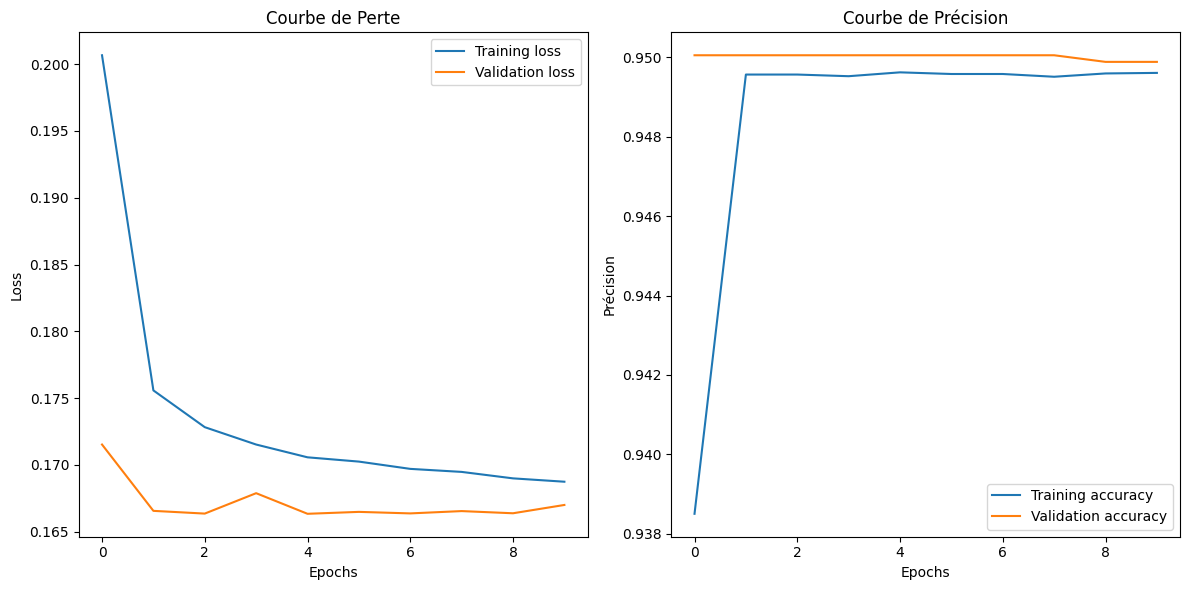

In [21]:
######################## deux en un  pour laures ########################

import matplotlib.pyplot as plt

# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

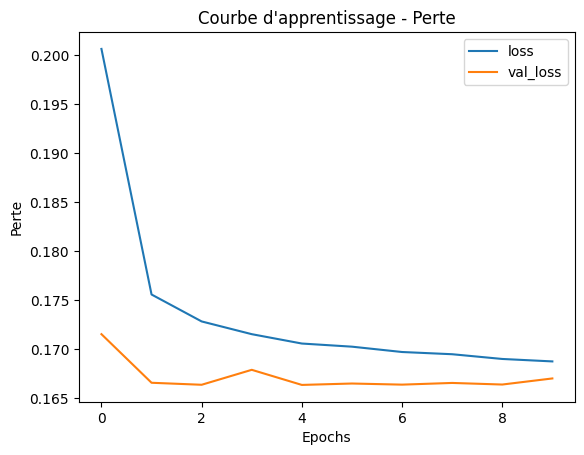

In [22]:
import matplotlib.pyplot as plt

# Plotter la courbe de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Courbe d\'apprentissage - Perte')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.show()


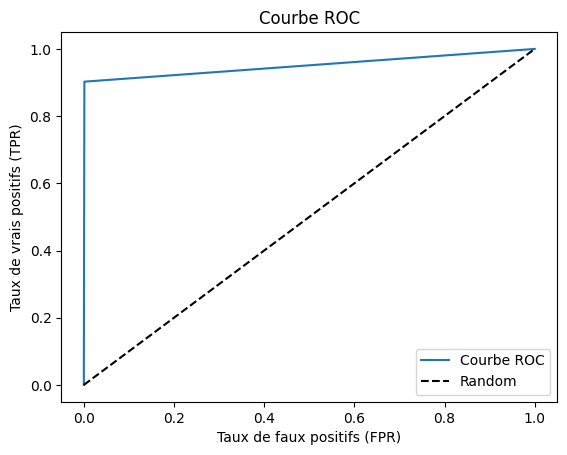

Aire sous la courbe (AUC) : 0.9506689933365674


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcul des taux FPR et TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plotter la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_pred)
print('Aire sous la courbe (AUC) :', auc)


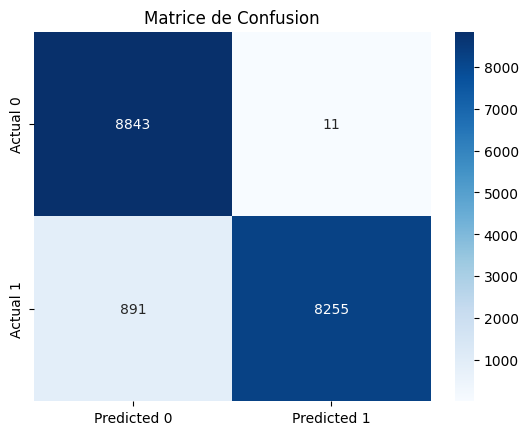

In [24]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix




#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(y_test,y_pred)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()


# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()
